In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import bayesflow as bf
from scipy.stats import truncnorm

In [4]:
RNG = np.random.default_rng(seed=None)

In [121]:
def rl_diffusion_trial(params, input, dt=.01, max_steps=900.):
    """Simulates a trial from the diffusion model."""
    # Parameters
    drift, alpha, beta, tau, kappa = params

    # RT and Choice from previous trials
    # Q-values from previous trials
    qs = [input[0], input[1]]
    # Potential outcomes
    outcome = [input[2], input[3]]

    # Intialzie evidence accumulation
    n_steps = 0.
    evidence = alpha * beta

    # trial-to-trial drift rate
    drift_trial = drift * (qs[0] - qs[1])
    print(np.round(drift_trial, 2), np.round(qs, 2))
    
    # Simulate a single DM path
    while ((evidence > 0) and (evidence < alpha) and (n_steps < max_steps)):

        # DDM equation
        evidence += drift_trial*dt + np.sqrt(dt) * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt + tau

    if evidence >= alpha:
        choice =  0  # choice A
        outcome[1] = 0 # So didn't see outcome of option B

    elif evidence <= 0:
        choice = 1  # choice B
        outcome[0] = 0 # So didn't see outcome of option A
    else:
        choice = -1  # This indicates a missing response

    # Q-learning
    if choice > -1:
        # Generate Signed RPE
        RPE = (outcome[choice] - qs[choice])
        # Update Q-value of previously chosen option
        qs[choice] = qs[choice] + kappa * RPE

    return rt, choice, outcome[0], outcome[1], qs[0], qs[1]

def experiment(theta, outcome_mat, num_obs):
    output = np.zeros((num_obs, 6))
    context = np.zeros((num_obs+1, 4))
    context[0,:2] = 0.5 # Initialize Q-values at 0.5
    context[0:num_obs,2:] = outcome_mat # Potential outcome of current rounds
    for n in range(num_obs):  
        check = 0
        while check == 0:
            output[n, :] = rl_diffusion_trial(params = theta,
                                        input = context[n,:]
            )
            # Repeat trial if response returned is -1
            if output[n, 1] > -1:
                check = 1
        # Store Q values
        context[(n+1),:2] = output[n,4:]

    #out = np.c_[context[1:,:]] # If we want EVERYTHING
    out = np.c_[output[:,:4]] # Only want choice,  RT, and feedback
    return out

MIN_OBS = 60
MAX_OBS = 60
NUM_CONDITIONS = 1

def random_num_obs(min_obs=MIN_OBS, max_obs=MAX_OBS):
    """Draws a random number of observations for all simulations in a batch."""

    return RNG.integers(low=min_obs, high=max_obs + 1)

context_gen = bf.simulation.ContextGenerator(
    non_batchable_context_fun=random_num_obs,
    batchable_context_fun=generate_outcomes_matrix,
    use_non_batchable_for_batchable=True,
)

prior = bf.simulation.Prior(
    prior_fun = draw_prior,
    param_names = ["drift", "a", "beta", "ndt", "eta"]
)


# Connect via BayesFlow Wrappers
simulator = bf.simulation.Simulator(simulator_fun=experiment, 
                                    context_generator=context_gen)
model = bf.simulation.GenerativeModel(prior=prior, 
                                      simulator=simulator, 
                                      name="RLDDM")

prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=100000)
prior_means = np.round(prior_means, decimals=1)
prior_stds = np.round(prior_stds, decimals=1)

def configurator(forward_dict):

    # Prepare placeholder dict
    out_dict = {}

    # Extract data
    data = forward_dict["sim_data"].astype(np.float32)

    # Extract context
    context = np.array(forward_dict["sim_batchable_context"])[..., None]

    # Convert to 3D
    outcomes = context.reshape((context.shape[0],context.shape[1],context.shape[2]))

    # Concatenate
    out_dict["summary_conditions"] = np.c_[data, outcomes].astype(np.float32)#np.c_[data[:, :, :4], outcomes].astype(np.float32)

    # These will be concatenated to the outputs of the summary network
    # Convert N to log N since neural nets cant deal well with large numbers
    N = np.log(forward_dict['sim_non_batchable_context'])

    # Repeat N for each sim (since shared across batch), notice the
    # extra dimension needed
    N_vec = N * np.ones((data.shape[0], 1), dtype=np.float32)
    out_dict['direct_conditions'] = N_vec

    # Finally, extract parameters. Any transformations (e.g., standardization)
    # should happen here.
    out_dict['parameters'] = forward_dict['prior_draws'].astype(np.float32)

    return out_dict

summary_net = bf.networks.TimeSeriesTransformer(input_dim=6, summary_dim=32, name="RLDDM_summary")

# Inference network
inference_net = bf.networks.InvertibleNetwork(
    num_params=len(prior.param_names),
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False},
    name="RLDDM_inference",
)

# Amortized Posterior

amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, name="DDM_amortizer")

# If the checkpoint path does not exist, create it
model_name = "RLDDM"

checkpoint_path = f"checkpoint/{model_name}"

# Define the trainer
trainer = bf.trainers.Trainer(
    generative_model=model, 
    amortizer=amortizer, 
    configurator=configurator, 
    checkpoint_path=checkpoint_path
)

# # Training Phase
# BATCH_SIZE = 16
# NUM_EPOCHS = 50
# NUM_ITER_PER_EPOCHS = 500

# history = trainer.train_online(NUM_EPOCHS, NUM_ITER_PER_EPOCHS, BATCH_SIZE)

# # Generate some validation data
# validation_sims = configurator(model(batch_size=1000))

# # Extract unstandardized prior draws and transform to original scale
# prior_samples = validation_sims["parameters"] * prior_stds + prior_means

# # Generate 100 posterior draws for each of the 1000 simulated data sets
# post_samples = amortizer.sample(validation_sims, n_samples=100)

# # Unstandardize posterior draws into original scale
# post_samples = post_samples * prior_stds + prior_means


# post_samples = amortizer.sample(validation_sims, n_samples=1000)
# post_samples = post_samples * prior_stds + prior_means

# # Model recoverabiltiy
# f = bf.diagnostics.plot_recovery(
#         post_samples, prior_samples, param_names=prior.param_names, point_agg=np.mean, uncertainty_agg=np.std
#     )

INFO:root:Performing 2 pilot runs with the RLDDM model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 60, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Shape of simulation non-batchable context: ()
INFO:root:Could not determine shape of simulation batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes cares of that!


-0.0 [0.5 0.5]
-0.05 [0.62 0.5 ]
-0.09 [0.62 0.38]
-0.13 [0.72 0.38]
-0.16 [0.72 0.28]
-0.19 [0.72 0.21]
-0.22 [0.79 0.21]
-0.24 [0.79 0.16]
-0.26 [0.84 0.16]
-0.27 [0.88 0.16]
-0.29 [0.88 0.12]
-0.3 [0.91 0.12]
-0.31 [0.93 0.12]
-0.22 [0.93 0.34]
-0.16 [0.93 0.5 ]
-0.08 [0.7 0.5]
-0.03 [0.7  0.63]
0.04 [0.53 0.63]
-0.01 [0.64 0.63]
0.05 [0.49 0.63]
0.1 [0.37 0.63]
0.13 [0.37 0.72]
0.07 [0.52 0.72]
0.1 [0.52 0.79]
0.15 [0.39 0.79]
0.09 [0.54 0.79]
0.02 [0.54 0.59]
0.06 [0.54 0.69]
-0.01 [0.54 0.52]
-0.06 [0.54 0.39]
-0.01 [0.41 0.39]
-0.04 [0.41 0.3 ]
-0.07 [0.41 0.22]
-0.09 [0.41 0.17]
-0.01 [0.41 0.37]
-0.07 [0.56 0.37]
-0.1 [0.56 0.28]
-0.04 [0.56 0.46]
-0.08 [0.67 0.46]
-0.02 [0.5  0.46]
-0.06 [0.62 0.46]
-0.0 [0.47 0.46]
-0.05 [0.47 0.35]
-0.1 [0.6  0.35]
-0.04 [0.6  0.51]
-0.08 [0.6  0.38]
-0.12 [0.7  0.38]
-0.06 [0.7  0.53]
-0.02 [0.7  0.65]
-0.05 [0.77 0.65]
-0.01 [0.77 0.74]
-0.08 [0.77 0.55]
-0.1 [0.83 0.55]
-0.12 [0.87 0.55]
-0.17 [0.87 0.42]
-0.18 [0.9  0.42]
-0.22 [0.9  0.

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...


-0.0 [0.5 0.5]
-0.31 [0.5  0.27]
-0.48 [0.5  0.14]
0.06 [0.5  0.54]
0.34 [0.5  0.76]
0.03 [0.73 0.76]
-0.14 [0.86 0.76]
0.4 [0.46 0.76]
0.06 [0.71 0.76]
0.51 [0.38 0.76]
0.12 [0.67 0.76]
0.54 [0.36 0.76]
0.69 [0.36 0.87]
0.91 [0.19 0.87]
1.03 [0.1  0.87]
1.09 [0.05 0.87]
0.5 [0.5  0.87]
0.81 [0.26 0.87]
0.98 [0.14 0.87]
1.07 [0.08 0.87]
1.11 [0.04 0.87]
1.14 [0.02 0.87]
1.15 [0.01 0.87]
1.16 [0.01 0.87]
1.24 [0.01 0.93]
0.62 [0.47 0.93]
0.29 [0.72 0.93]
-0.3 [0.72 0.5 ]
-0.61 [0.72 0.26]
-0.16 [0.38 0.26]
-0.55 [0.67 0.26]
-0.75 [0.82 0.26]
-0.29 [0.82 0.61]
-0.67 [0.82 0.32]
-0.87 [0.82 0.17]
-0.98 [0.82 0.09]
-1.04 [0.82 0.05]
-0.52 [0.44 0.05]
0.07 [0.44 0.49]
-0.24 [0.44 0.26]
0.04 [0.23 0.26]
0.19 [0.12 0.26]
0.26 [0.07 0.26]
0.3 [0.04 0.26]
0.77 [0.04 0.61]
0.79 [0.02 0.61]
0.8 [0.01 0.61]
0.81 [0.01 0.61]
0.81 [0.   0.61]
0.19 [0.47 0.61]
-0.19 [0.47 0.32]
-0.53 [0.72 0.32]
-0.08 [0.38 0.32]
0.35 [0.38 0.64]
-0.04 [0.67 0.64]
-0.44 [0.67 0.34]
-0.65 [0.82 0.34]
-0.24 [0.82 0.65]

INFO:root:Done.


In [69]:
def generate_outcomes_matrix(num_obs,probs = [0.8, 0.2]):
    outcome_mat = np.zeros([num_obs,2])
    for n in range(num_obs):
        # Every 12 trials, reverse probabilities
        if (n > 1) & (n % 12 == 0):
            probs = [probs[1], probs[0]]
            
        # Pre-allocate outcomes of each bandit
        outcome_mat[n,0] = np.random.binomial(n=1,p = probs[0])
        outcome_mat[n,1] = np.random.binomial(n=1,p = probs[1])

    return outcome_mat

In [70]:
# Generative Model Specifications User Defined Functions, non-batchable
def truncnorm_better(mean=0, sd=1, low=-10, upp=10, size=1):
    return truncnorm.rvs(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd, size=size)

def draw_prior():
    # drift ~ N(0, 2.0), mean drift rate, index 0
    drift = RNG.normal(0.0, 2.0)
    # alpha ~ N(1.0, 0.5) in [0, 5], boundary
    alpha = truncnorm_better(mean=1.0, sd=0.5, low=0.0, upp=5)[0]
    # beta ~ Beta(2.0, 2.0), relative start point
    beta = RNG.beta(2.0, 2.0)
    # ter ~ N(0.5, 0.25) in [0, 1.5], non-decision time
    ter = truncnorm_better(mean=0.5, sd=0.25, low=0.0, upp=1.5)[0]
    # eta ~ N(1.0, 0.5) in [0, 3], trial-to-trial variability in drift, index 4
    # eta = truncnorm_better(mean=1.0, sd=0.5, low=0.0, upp=3)[0]
    # kappa ~ Beta(2.0, 2.0), learning rate
    kappa = RNG.beta(2.0, 2.0)
    p_samples = np.hstack((drift, alpha, beta, ter, kappa))
    return p_samples

In [71]:
draw_prior()

array([0.64088512, 1.24946203, 0.22688237, 0.41858041, 0.06937954])

In [72]:
drift, alpha, beta, tau, kappa = params

In [81]:
context = generate_outcomes_matrix(60)

In [109]:
params = np.array([1, 2, 0.5, 0.3, 0.8])

In [118]:
sim = experiment(params, context, 60)

0.0 [0.5 0.5]
0.4 [0.9 0.5]
-0.32 [0.18 0.5 ]
0.34 [0.84 0.5 ]
0.74 [0.84 0.1 ]
0.82 [0.84 0.02]
0.95 [0.97 0.02]
0.97 [0.99 0.02]
0.98 [1.   0.02]
0.99 [1. 0.]
1.0 [1. 0.]
0.2 [1.  0.8]
-0.6 [0.2 0.8]
-0.76 [0.2  0.96]
-0.92 [0.04 0.96]
-0.95 [0.04 0.99]
-0.96 [0.04 1.  ]
-0.96 [0.04 1.  ]
-0.96 [0.04 1.  ]
-0.96 [0.04 1.  ]
-0.16 [0.04 0.2 ]
-0.8 [0.04 0.84]
-0.83 [0.01 0.84]
-0.96 [0.01 0.97]
-0.99 [0.01 0.99]
-0.19 [0.01 0.2 ]
-0.03 [0.01 0.04]
0.76 [0.8  0.04]
0.92 [0.96 0.04]
0.95 [0.99 0.04]
0.16 [0.2  0.04]
0.8 [0.84 0.04]
0.93 [0.97 0.04]
0.95 [0.99 0.04]
0.16 [0.2  0.04]
-0.0 [0.04 0.04]
0.03 [0.04 0.01]
0.8 [0.81 0.01]
0.01 [0.81 0.8 ]
0.16 [0.96 0.8 ]
0.0 [0.96 0.96]
-0.77 [0.19 0.96]
0.0 [0.19 0.19]
-0.15 [0.04 0.19]
-0.8 [0.04 0.84]
-0.93 [0.04 0.97]
-0.96 [0.01 0.97]
-0.99 [0.01 0.99]
-0.99 [0.   0.99]
-1.0 [0. 1.]
-1.0 [0. 1.]
-0.2 [0.  0.2]
-0.04 [0.   0.04]
0.76 [0.8  0.04]
0.92 [0.96 0.04]
0.95 [0.99 0.04]
0.96 [1.   0.04]
0.19 [1.   0.81]
0.84 [1.   0.16]
0.84 [1.  

In [122]:
x= RNG.beta(2.0, 2.0, 10000)

<Axes: ylabel='Count'>

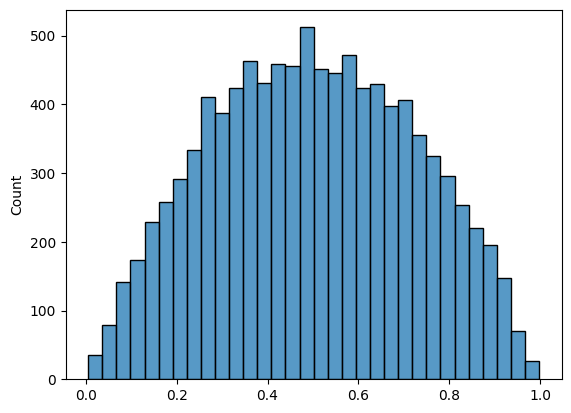

In [123]:
import seaborn as sns
sns.histplot(x)

In [124]:
sim_data = model(100)

0.0 [0.5 0.5]
0.13 [0.5  0.37]
0.26 [0.63 0.37]
0.36 [0.73 0.37]
0.43 [0.8  0.37]
0.48 [0.86 0.37]
0.32 [0.86 0.54]
0.19 [0.86 0.66]
0.1 [0.86 0.75]
0.14 [0.89 0.75]
-0.09 [0.66 0.75]
-0.0 [0.75 0.75]
-0.2 [0.55 0.75]
-0.35 [0.4  0.75]
-0.15 [0.4  0.55]
-0.27 [0.4  0.67]
-0.09 [0.4  0.49]
0.07 [0.56 0.49]
-0.07 [0.56 0.63]
-0.16 [0.56 0.73]
0.03 [0.56 0.53]
0.17 [0.56 0.39]
0.01 [0.56 0.55]
-0.11 [0.56 0.67]
-0.2 [0.56 0.76]
-0.08 [0.68 0.76]
-0.26 [0.5  0.76]
-0.06 [0.5  0.56]
-0.18 [0.5  0.68]
-0.04 [0.63 0.68]
-0.21 [0.46 0.68]
-0.03 [0.46 0.49]
0.11 [0.61 0.49]
-0.05 [0.44 0.49]
0.08 [0.44 0.36]
-0.09 [0.44 0.53]
0.05 [0.44 0.39]
-0.11 [0.44 0.55]
-0.23 [0.44 0.67]
-0.31 [0.44 0.76]
-0.38 [0.44 0.82]
-0.42 [0.44 0.87]
-0.46 [0.44 0.91]
-0.48 [0.44 0.93]
-0.5 [0.44 0.95]
-0.35 [0.59 0.95]
-0.37 [0.59 0.96]
-0.38 [0.59 0.97]
-0.38 [0.59 0.98]
-0.12 [0.59 0.72]
0.07 [0.59 0.53]
0.21 [0.59 0.39]
0.05 [0.43 0.39]
0.2 [0.59 0.39]
0.31 [0.7  0.39]
0.41 [0.7  0.28]
0.48 [0.7  0.21]
0.54 [0

In [125]:
test = configurator(sim_data)

In [127]:
test['summary_conditions'][0]

array([[0.7353271, 1.       , 0.       , 0.       , 1.       , 0.       ],
       [1.4053271, 0.       , 1.       , 0.       , 1.       , 0.       ],
       [1.3453271, 0.       , 1.       , 0.       , 1.       , 1.       ],
       [0.9053271, 0.       , 1.       , 0.       , 1.       , 0.       ],
       [0.8653271, 0.       , 1.       , 0.       , 1.       , 0.       ],
       [1.4853271, 1.       , 0.       , 1.       , 1.       , 1.       ],
       [0.7153271, 1.       , 0.       , 1.       , 1.       , 1.       ],
       [0.7053271, 1.       , 0.       , 1.       , 1.       , 1.       ],
       [1.445327 , 0.       , 1.       , 0.       , 1.       , 0.       ],
       [0.9953271, 0.       , 0.       , 0.       , 0.       , 1.       ],
       [1.0353271, 0.       , 1.       , 0.       , 1.       , 0.       ],
       [0.8053271, 0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.9353271, 0.       , 0.       , 0.       , 0.       , 1.       ],
       [0.7053271, 1.    

In [ ]:
def configurator(forward_dict):
    # Prepare placeholder dict
    out_dict = {}
    # Extract data
    data = forward_dict["sim_data"].astype(np.float32)
    # Extract context
    context = np.array(forward_dict["sim_batchable_context"])[..., None]
    # Convert to 3D
    outcomes = context.reshape((context.shape[0],context.shape[1],context.shape[2]))
    # Concatenate
    out_dict["summary_conditions"] = np.c_[data, outcomes].astype(np.float32)#np.c_[data[:, :, :4], outcomes].astype(np.float32)
    # These will be concatenated to the outputs of the summary network
    # Convert N to log N since neural nets cant deal well with large numbers
    N = np.log(forward_dict['sim_non_batchable_context'])
    # Repeat N for each sim (since shared across batch), notice the
    # extra dimension needed
    N_vec = N * np.ones((data.shape[0], 1), dtype=np.float32)
    out_dict['direct_conditions'] = N_vec
    # Finally, extract parameters. Any transformations (e.g., standardization)
    # should happen here.
    out_dict['parameters'] = forward_dict['prior_draws'].astype(np.float32)

    return out_dict

In [130]:
sim_data['sim_batchable_context'][0].shape

(60, 2)

In [131]:
context = np.array(sim_data['sim_batchable_context'])[..., None]
context.shape

(100, 60, 2, 1)

In [132]:
outcomes = context.reshape((context.shape[0],context.shape[1],context.shape[2]))
outcomes.shape

(100, 60, 2)

In [135]:
forward_dict = sim_data

In [136]:
data = forward_dict["sim_data"].astype(np.float32)
data.shape

(100, 60, 4)

In [134]:
configurator(sim_data)['summary_conditions'].shape

(100, 60, 6)